In [1]:
import os
import tarfile
import numpy as np

from PIL import Image
import PIL
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision.transforms import Compose, RandomCrop, ToTensor, Resize, ToPILImage, CenterCrop

In [2]:
def is_image_file(filename):
    return any(filename.endswith(extension) for extension in ['bmp', '.png', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG'])

class DatasetFromfolder(Dataset):
    def __init__(self, path):
        super(DatasetFromfolder, self).__init__()
        self.filenames = []
        folders = os.listdir(path)
        for f in folders:
            self.filenames.append(path + f)
        self.data_transform = Compose([RandomCrop([33, 33]), ToTensor()])
        self.data_transform_PIL = Compose([ToPILImage()])

    def __getitem__(self, index):        
        w = h = 512
        img = Image.open(self.filenames[index])
        img, _cb, _cr = img.convert('YCbCr').split()     
        img = self.data_transform(img)           
        result_image = img
        
        resize_image = self.data_transform_PIL(img)        
        #resize_image = resize_image.resize(512,512)
        resize_image = resize_image.resize((w, h), Image.BICUBIC)
        resize_image = self.data_transform(resize_image) 
        
        return result_image, resize_image

    def __len__(self):
        return len(self.filenames)

In [3]:
root_dir = '../input/dataset-drd/'

In [21]:
test_path_normal = os.path.join(root_dir, "test/0/")

test_img_normal_paths = sorted(
    [
        os.path.join(test_path_normal, fname)
        for fname in os.listdir(test_path_normal)
        if fname.endswith(".jpg")
    ]
)

In [22]:
len(test_img_normal_paths)

200

In [23]:
test_path_pneumonia = os.path.join(root_dir, "test/1")

test_img_pneumonia_paths = sorted(
    [
        os.path.join(test_path_pneumonia, fname)
        for fname in os.listdir(test_path_pneumonia)
        if fname.endswith(".jpg")
    ]
)

In [6]:
class SuperResolutionCNN(nn.Module):
    def __init__(self):
        super(SuperResolutionCNN, self).__init__()
        self.Conv1 = nn.Conv2d(1, 64, 9, 1, 4)
        self.Conv2 = nn.Conv2d(64, 32, 3, 1, 1)
        self.Conv3 = nn.Conv2d(32, 1, 5, 1, 2)
        self.Relu = nn.ReLU()
        self.sig = nn.Sigmoid()

    def forward(self, x):
        out = self.Relu(self.Conv1(x))
        out = self.Relu(self.Conv2(out))
        out = self.Conv3(out)
        return out

In [7]:
data_transform = Compose([ToTensor()])    
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_set = DatasetFromfolder('../input/dataset-drd/train/')
train_loader = DataLoader(dataset=train_set, num_workers=0, batch_size=32, shuffle=True)

SRCNN = SuperResolutionCNN()
if torch.cuda.device_count() > 1:
    SRCNN = nn.DataParallel(SRCNN)
SRCNN.to(device)    

optimizer = optim.Adam(SRCNN.parameters())
criterion = nn.MSELoss().to(device)

#new_point = 0
os.system('mkdir /tmp/checkpoint')
os.system('mkdir /tmp/image')

0

In [8]:
def train(NUM_EPOCHS=1):
    #NUM_EPOCHS = 10 #501
#     data_transform = Compose([ToTensor()])    
    
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#     train_set = DatasetFromfolder('../input/xray-normal/xray_dataset_normal/train/')
#     train_loader = DataLoader(dataset=train_set, num_workers=0, batch_size=64, shuffle=True)
    
#     SRCNN = SuperResolutionCNN()
#     if torch.cuda.device_count() > 1:
#         SRCNN = nn.DataParallel(SRCNN)
#     SRCNN.to(device)    
    
#     optimizer = optim.Adam(SRCNN.parameters())
#     criterion = nn.MSELoss().to(device)
    
    new_point = 0
#     os.system('mkdir checkpoint')
#     os.system('mkdir image')
    
    for epoch in range(NUM_EPOCHS+1):        
        batch_idx = 0        
        for HR, LR in train_loader:
            HR = HR.to(device)
            LR = LR.to(device)            
            newHR = SRCNN(LR) 
            
            SRCNN.train()
            SRCNN.zero_grad()
            loss = criterion(HR, newHR)
            loss.backward(retain_graph=True)
            optimizer.step()
            
            if epoch%50==0 and batch_idx%1==0:
                SRCNN.eval()
                print("Epoch:{} batch[{}/{}] loss:{}".format(epoch, batch_idx, len(train_loader), loss))      
                
                img = Image.open('../input/dataset-drd/test/0/115_left.jpg')   
                            
                w, h = img.size
                
                result_image = img
                result_image_y, _cb, _cr = result_image.convert('YCbCr').split()
                result_image_y = data_transform(result_image_y)   
                
        
                resize_image = img.resize((int(w/2), int(h/2)), Image.BICUBIC)       
                resize_image = resize_image.resize((w, h), Image.BICUBIC)
                resize_image_y, _cb1, _cr1 = resize_image.convert('YCbCr').split()
                resize_image_y = data_transform(resize_image_y).to(device)
                newHR = SRCNN(resize_image_y.unsqueeze(0))
                #print(newHR[0].shape)
                out_img_y = newHR[0]
                out_img_y *= 255.0
                out_img_y = out_img_y.cpu().data.numpy()
                # Restore the image in RGB color space.
                out_img_y = out_img_y.clip(0, 255)
                out_img_y = out_img_y.reshape((np.shape(out_img_y)[1], np.shape(out_img_y)[2]))
                out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
                out_img_cb = _cb1.resize(out_img_y.size, PIL.Image.BICUBIC)
                out_img_cr = _cr1.resize(out_img_y.size, PIL.Image.BICUBIC)
                out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert("RGB")
                
                resize_image.save(f'/tmp/image/LR{epoch}.png')
                result_image.save(f'/tmp/image/HR{epoch}.png')
                out_img.save(f'/tmp/image/newHR{epoch}.png')
                
                im1 = Image.open(f'/tmp/image/LR{epoch}.png')
                im2 = Image.open(f'/tmp/image/HR{epoch}.png')
                im3 = Image.open(f'/tmp/image/newHR{epoch}.png')                
                dst = Image.new('RGB', (w*3 , h))
                dst.paste(im1, (0, 0))
                dst.paste(im2, (w, 0))
                dst.paste(im3, (w*2, 0))
                dst.save(f'/tmp/image/image{epoch}.png')
                img = Image.open(f'/tmp/image/image{epoch}.png')
                plt.imshow(img)
                plt.title(f'Image After {epoch} epochs')
                plt.show()
                
            batch_idx += 1
            
        torch.save(SRCNN.state_dict(), '/tmp/checkpoint/ckpt_%d.pth' % (new_point))
        new_point += 1

Epoch:0 batch[0/32] loss:0.36343687772750854


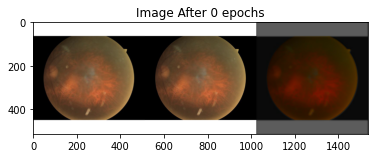

Epoch:0 batch[1/32] loss:0.0997617095708847


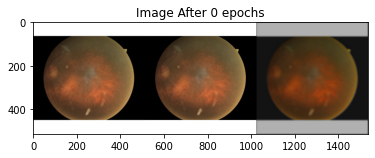

Epoch:0 batch[2/32] loss:0.10865844041109085


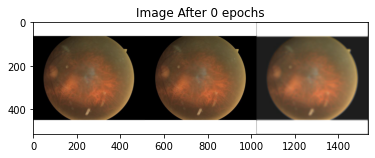

Epoch:0 batch[3/32] loss:0.05737258121371269


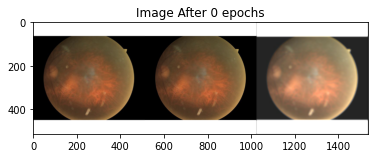

Epoch:0 batch[4/32] loss:0.07852146029472351


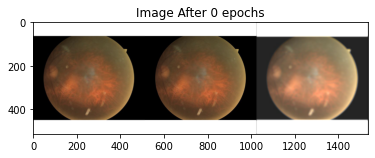

Epoch:0 batch[5/32] loss:0.143216073513031


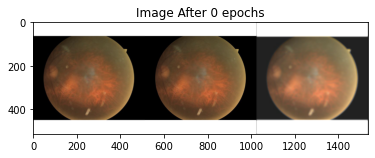

Epoch:0 batch[6/32] loss:0.07631437480449677


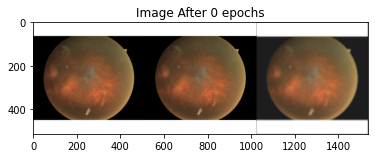

Epoch:0 batch[7/32] loss:0.045334719121456146


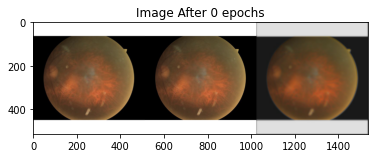

Epoch:0 batch[8/32] loss:0.05816543102264404


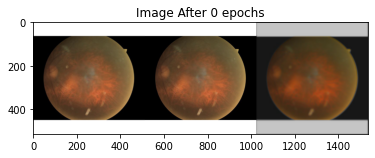

Epoch:0 batch[9/32] loss:0.06581803411245346


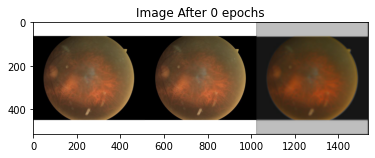

Epoch:0 batch[10/32] loss:0.08507906645536423


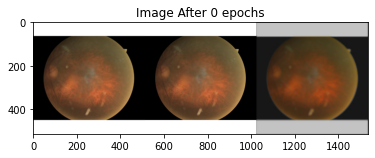

Epoch:0 batch[11/32] loss:0.06133396923542023


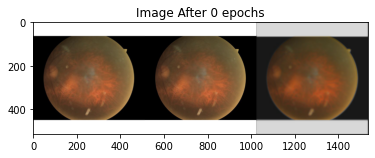

Epoch:0 batch[12/32] loss:0.06252124160528183


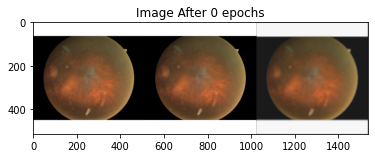

Epoch:0 batch[13/32] loss:0.043863847851753235


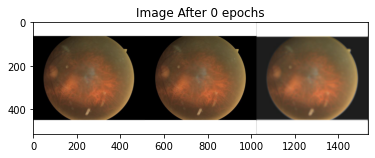

Epoch:0 batch[14/32] loss:0.0380406528711319


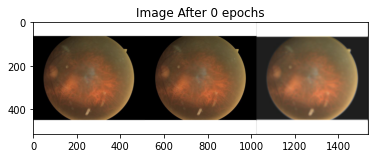

Epoch:0 batch[15/32] loss:0.06094324588775635


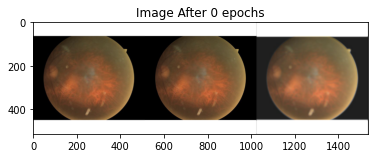

Epoch:0 batch[16/32] loss:0.038048192858695984


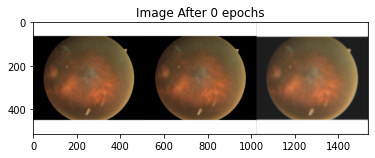

Epoch:0 batch[17/32] loss:0.06418033689260483


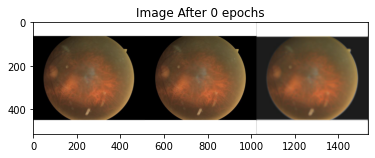

Epoch:0 batch[18/32] loss:0.03914779797196388


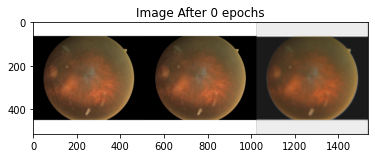

Epoch:0 batch[19/32] loss:0.027912424877285957


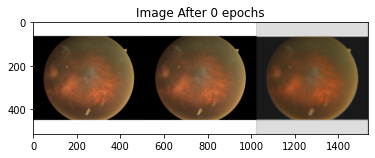

Epoch:0 batch[20/32] loss:0.035731490701436996


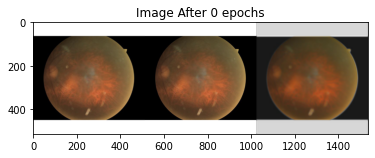

Epoch:0 batch[21/32] loss:0.07277484983205795


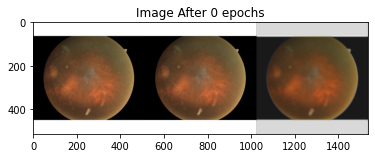

Epoch:0 batch[22/32] loss:0.028215700760483742


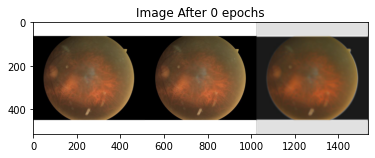

Epoch:0 batch[23/32] loss:0.03095024637877941


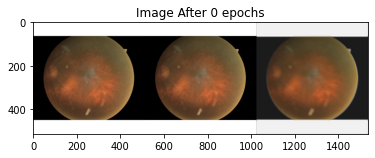

Epoch:0 batch[24/32] loss:0.015465836971998215


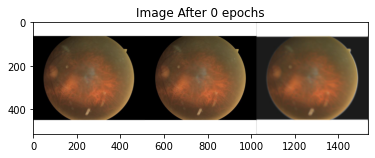

Epoch:0 batch[25/32] loss:0.03738795220851898


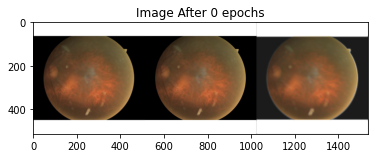

Epoch:0 batch[26/32] loss:0.028373437002301216


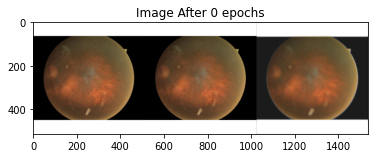

Epoch:0 batch[27/32] loss:0.04129558429121971


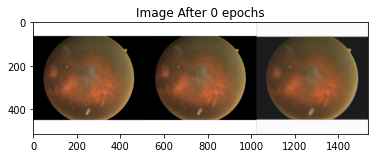

Epoch:0 batch[28/32] loss:0.039011966437101364


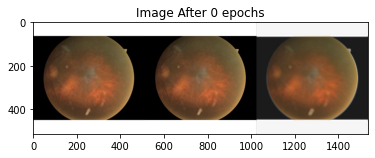

Epoch:0 batch[29/32] loss:0.03626096993684769


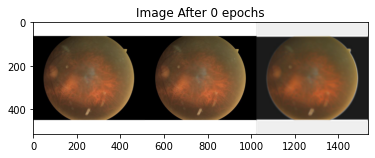

Epoch:0 batch[30/32] loss:0.05042490363121033


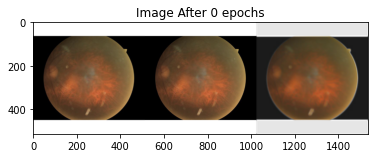

Epoch:0 batch[31/32] loss:0.041629645973443985


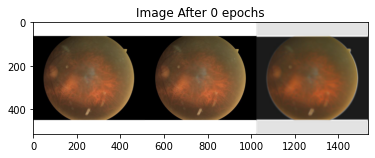

Epoch:50 batch[0/32] loss:0.030696844682097435


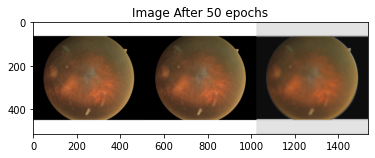

Epoch:50 batch[1/32] loss:0.03629037365317345


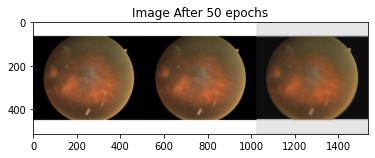

Epoch:50 batch[2/32] loss:0.06762982159852982


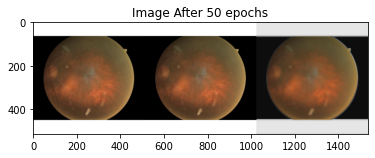

Epoch:50 batch[3/32] loss:0.03830820322036743


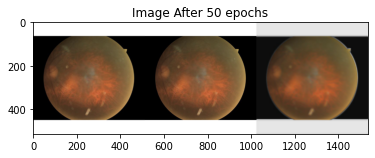

Epoch:50 batch[4/32] loss:0.008880694396793842


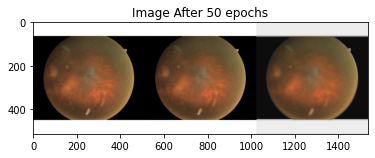

Epoch:50 batch[5/32] loss:0.04460987448692322


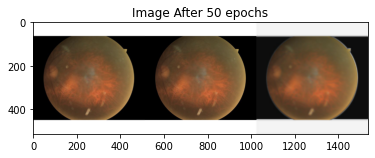

Epoch:50 batch[6/32] loss:0.0283830389380455


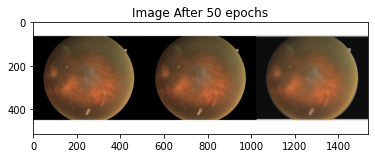

Epoch:50 batch[7/32] loss:0.030501093715429306


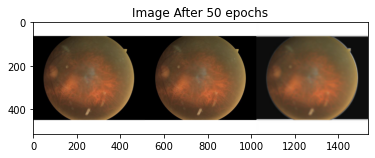

Epoch:50 batch[8/32] loss:0.014182169921696186


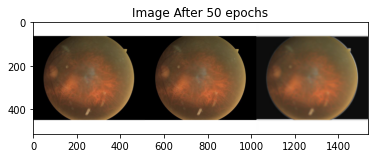

Epoch:50 batch[9/32] loss:0.029349245131015778


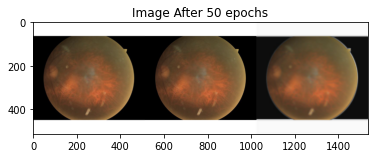

Epoch:50 batch[10/32] loss:0.029423361644148827


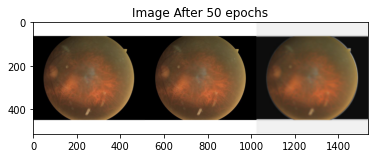

Epoch:50 batch[11/32] loss:0.021329738199710846


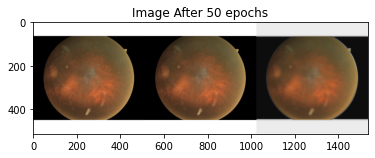

Epoch:50 batch[12/32] loss:0.03193831443786621


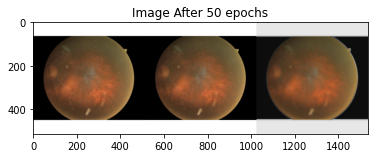

Epoch:50 batch[13/32] loss:0.03335194289684296


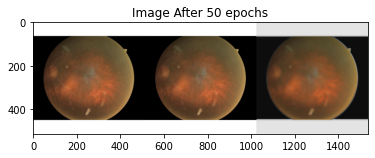

Epoch:50 batch[14/32] loss:0.025145430117845535


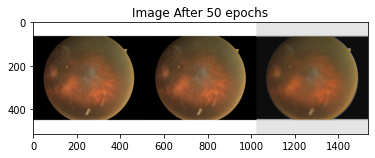

Epoch:50 batch[15/32] loss:0.05475075915455818


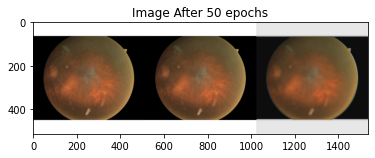

Epoch:50 batch[16/32] loss:0.06814085692167282


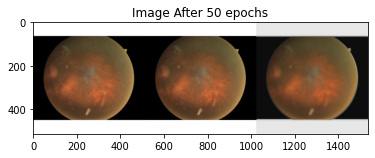

Epoch:50 batch[17/32] loss:0.041812241077423096


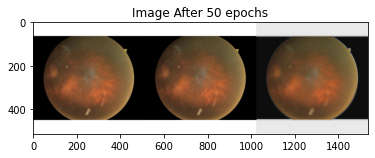

Epoch:50 batch[18/32] loss:0.021755142137408257


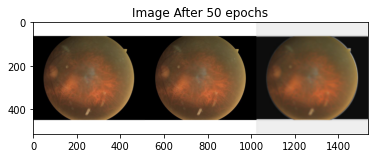

Epoch:50 batch[19/32] loss:0.02784668654203415


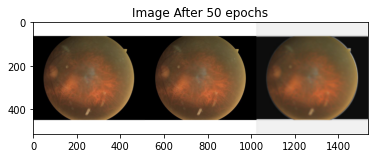

Epoch:50 batch[20/32] loss:0.0322444848716259


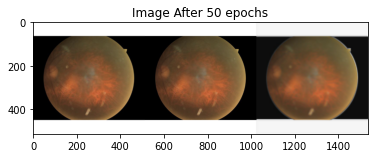

Epoch:50 batch[21/32] loss:0.04560527205467224


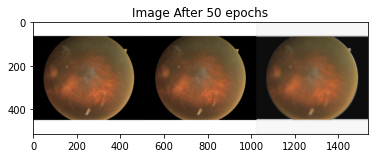

Epoch:50 batch[22/32] loss:0.048514679074287415


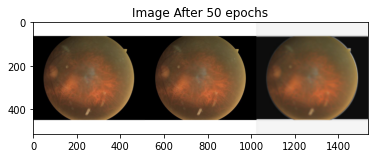

Epoch:50 batch[23/32] loss:0.01642739027738571


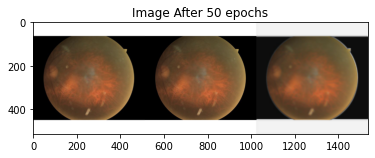

Epoch:50 batch[24/32] loss:0.028758075088262558


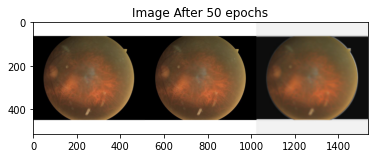

Epoch:50 batch[25/32] loss:0.046484414488077164


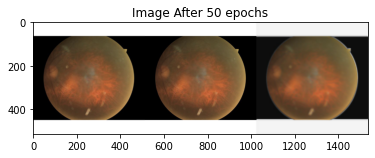

Epoch:50 batch[26/32] loss:0.06416993588209152


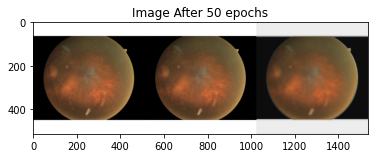

Epoch:50 batch[27/32] loss:0.015932155773043633


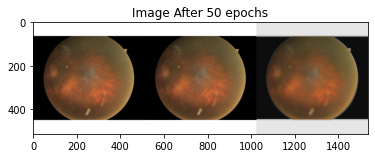

Epoch:50 batch[28/32] loss:0.028753802180290222


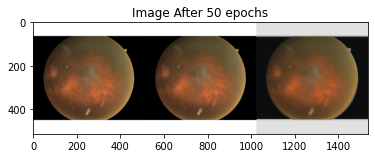

Epoch:50 batch[29/32] loss:0.056301992386579514


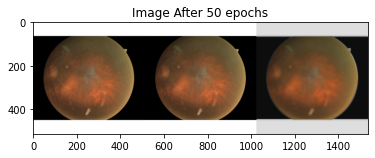

Epoch:50 batch[30/32] loss:0.04517728462815285


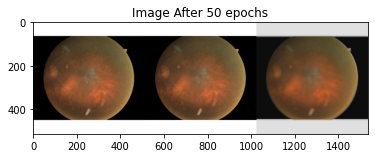

Epoch:50 batch[31/32] loss:0.042084306478500366


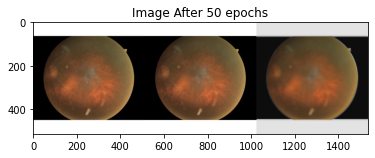

Epoch:100 batch[0/32] loss:0.03954499214887619


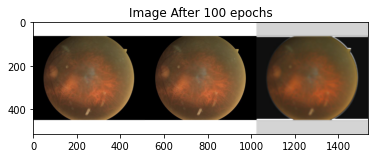

Epoch:100 batch[1/32] loss:0.025097450241446495


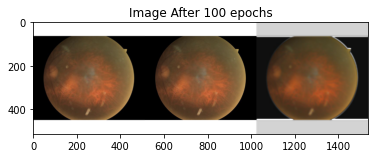

Epoch:100 batch[2/32] loss:0.035245370119810104


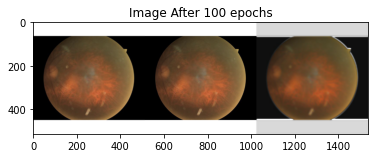

Epoch:100 batch[3/32] loss:0.059062570333480835


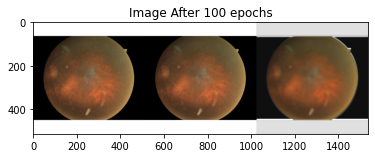

Epoch:100 batch[4/32] loss:0.05819566547870636


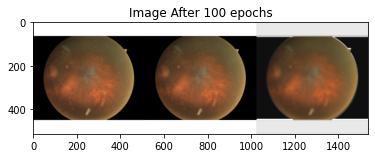

Epoch:100 batch[5/32] loss:0.022120654582977295


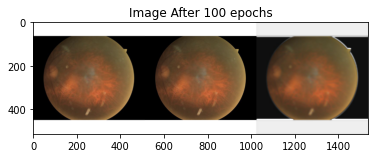

Epoch:100 batch[6/32] loss:0.0256938599050045


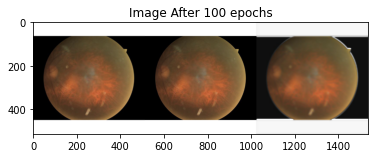

Epoch:100 batch[7/32] loss:0.013344770297408104


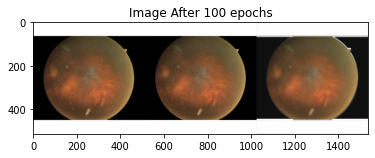

Epoch:100 batch[8/32] loss:0.03963503986597061


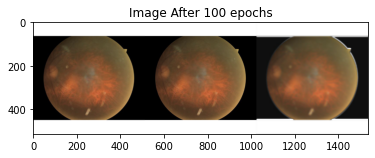

Epoch:100 batch[9/32] loss:0.010187235660851002


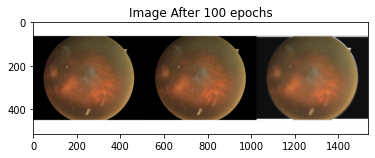

Epoch:100 batch[10/32] loss:0.03399866819381714


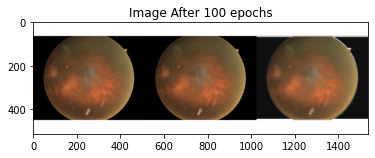

Epoch:100 batch[11/32] loss:0.10267528146505356


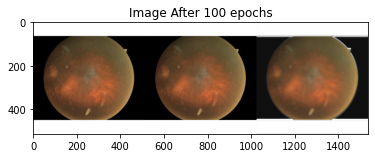

Epoch:100 batch[12/32] loss:0.047492269426584244


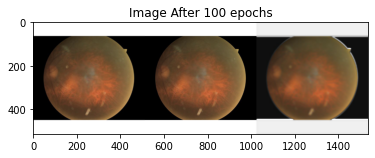

Epoch:100 batch[13/32] loss:0.04487993195652962


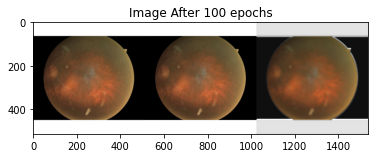

Epoch:100 batch[14/32] loss:0.03650054335594177


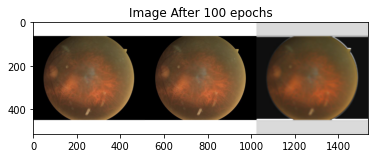

Epoch:100 batch[15/32] loss:0.03506531938910484


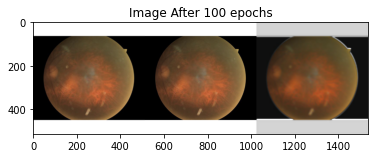

Epoch:100 batch[16/32] loss:0.04799862951040268


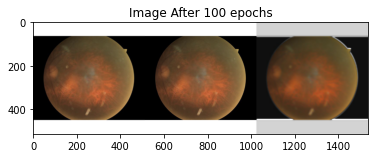

Epoch:100 batch[17/32] loss:0.04318646341562271


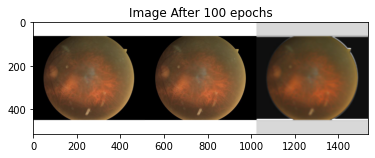

Epoch:100 batch[18/32] loss:0.07403313368558884


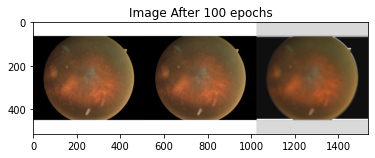

Epoch:100 batch[19/32] loss:0.026882773265242577


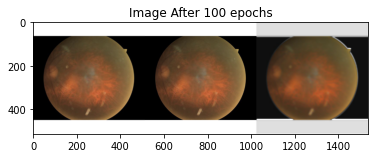

Epoch:100 batch[20/32] loss:0.04577980935573578


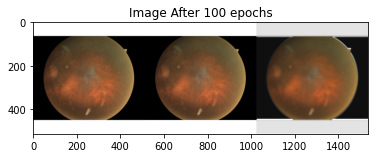

Epoch:100 batch[21/32] loss:0.03507465496659279


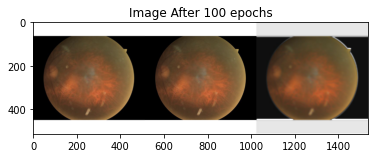

Epoch:100 batch[22/32] loss:0.05934026092290878


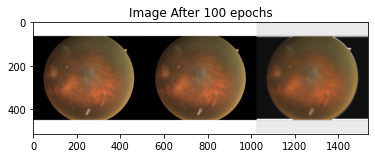

Epoch:100 batch[23/32] loss:0.06401105225086212


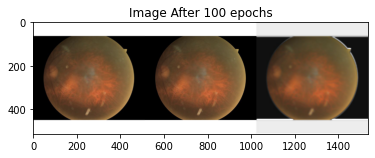

Epoch:100 batch[24/32] loss:0.03265233710408211


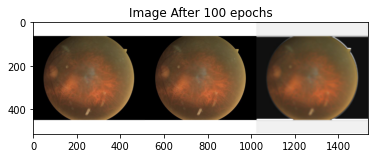

Epoch:100 batch[25/32] loss:0.05544457584619522


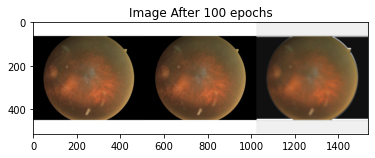

Epoch:100 batch[26/32] loss:0.036482978612184525


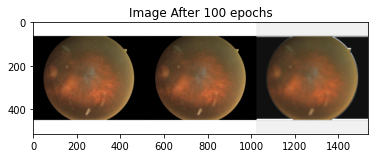

Epoch:100 batch[27/32] loss:0.06039072945713997


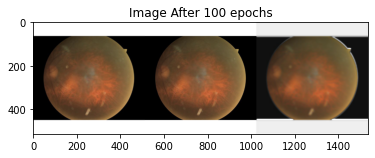

Epoch:100 batch[28/32] loss:0.029025545343756676


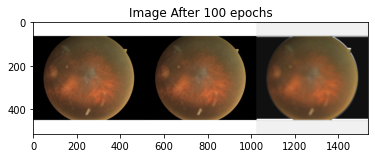

Epoch:100 batch[29/32] loss:0.03128642961382866


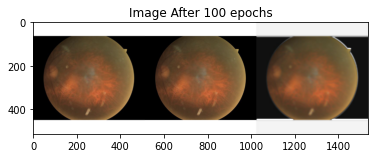

Epoch:100 batch[30/32] loss:0.044691864401102066


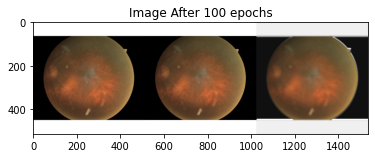

Epoch:100 batch[31/32] loss:0.04024738818407059


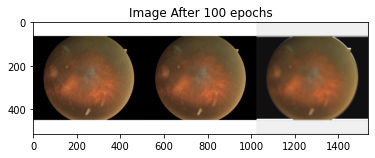

Epoch:150 batch[0/32] loss:0.05093887448310852


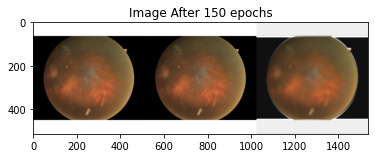

Epoch:150 batch[1/32] loss:0.03002772107720375


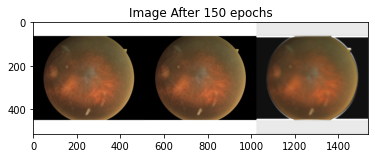

Epoch:150 batch[2/32] loss:0.05086604878306389


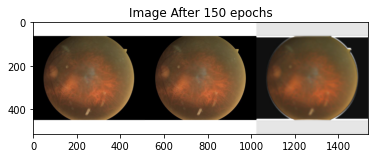

Epoch:150 batch[3/32] loss:0.02278725616633892


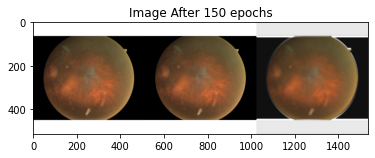

Epoch:150 batch[4/32] loss:0.05316940322518349


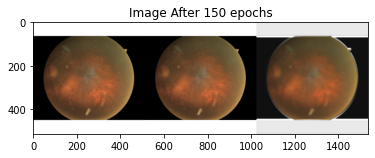

Epoch:150 batch[5/32] loss:0.01293816976249218


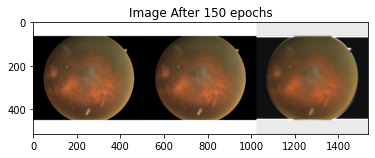

Epoch:150 batch[6/32] loss:0.043575990945100784


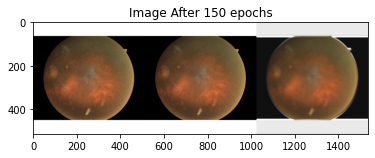

Epoch:150 batch[7/32] loss:0.034495413303375244


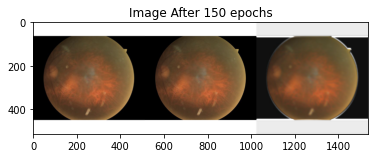

Epoch:150 batch[8/32] loss:0.04274339601397514


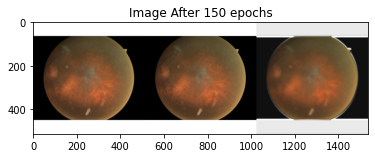

Epoch:150 batch[9/32] loss:0.01155915018171072


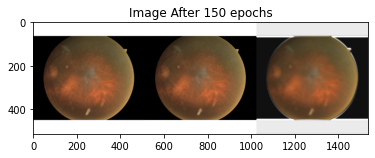

Epoch:150 batch[10/32] loss:0.02434101514518261


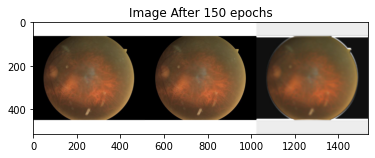

Epoch:150 batch[11/32] loss:0.04639371857047081


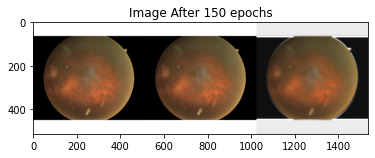

Epoch:150 batch[12/32] loss:0.039616964757442474


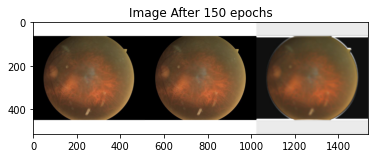

Epoch:150 batch[13/32] loss:0.013819871470332146


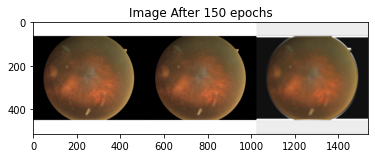

Epoch:150 batch[14/32] loss:0.08562053740024567


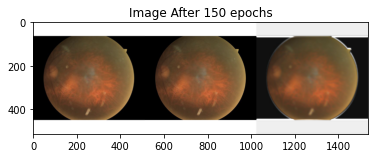

Epoch:150 batch[15/32] loss:0.040599383413791656


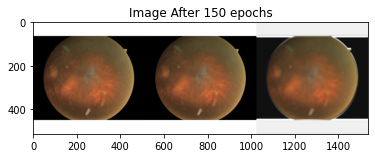

Epoch:150 batch[16/32] loss:0.03315727785229683


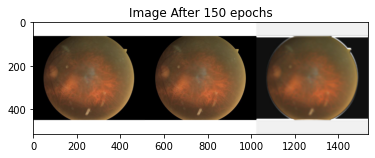

Epoch:150 batch[17/32] loss:0.03956088423728943


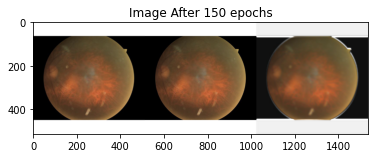

Epoch:150 batch[18/32] loss:0.023678120225667953


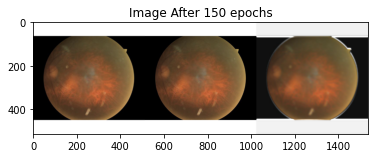

Epoch:150 batch[19/32] loss:0.03423752635717392


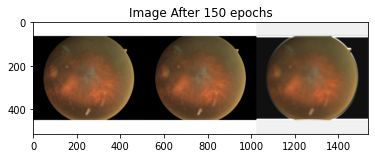

Epoch:150 batch[20/32] loss:0.03181379288434982


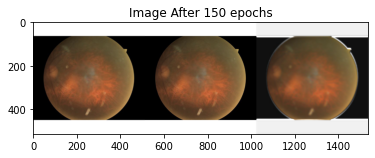

Epoch:150 batch[21/32] loss:0.035116177052259445


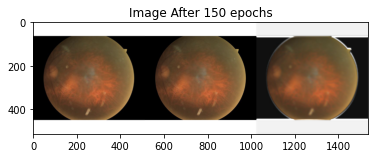

Epoch:150 batch[22/32] loss:0.025178514420986176


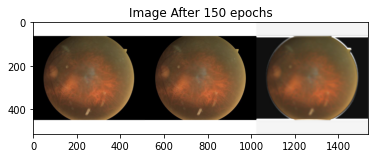

Epoch:150 batch[23/32] loss:0.01663210615515709


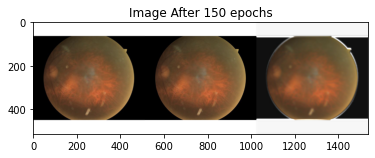

Epoch:150 batch[24/32] loss:0.03273578733205795


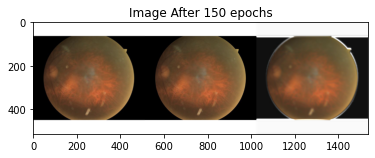

Epoch:150 batch[25/32] loss:0.023609889671206474


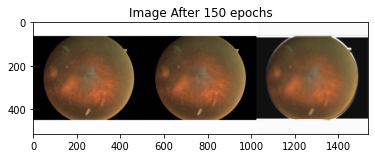

Epoch:150 batch[26/32] loss:0.028989309445023537


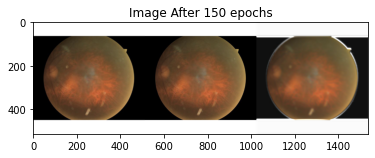

Epoch:150 batch[27/32] loss:0.04891897737979889


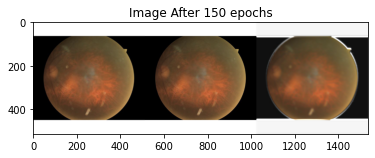

Epoch:150 batch[28/32] loss:0.020865002647042274


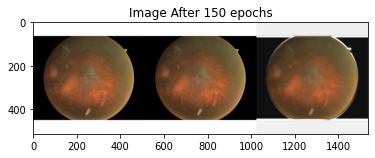

Epoch:150 batch[29/32] loss:0.008115543983876705


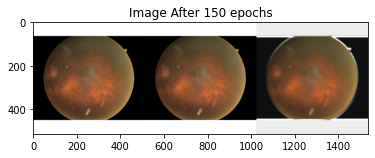

Epoch:150 batch[30/32] loss:0.03567882999777794


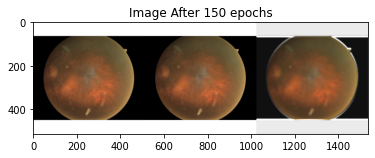

Epoch:150 batch[31/32] loss:0.052012503147125244


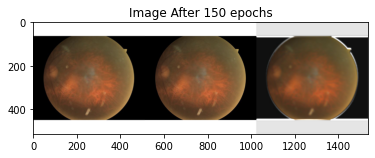

Epoch:200 batch[0/32] loss:0.05971599742770195


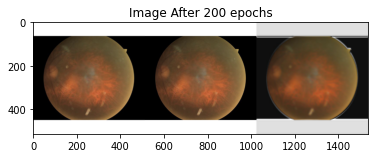

Epoch:200 batch[1/32] loss:0.07434174418449402


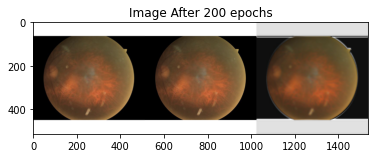

Epoch:200 batch[2/32] loss:0.09933750331401825


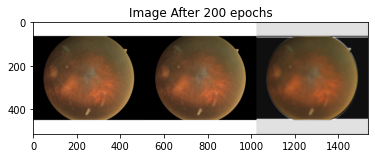

Epoch:200 batch[3/32] loss:0.026867633685469627


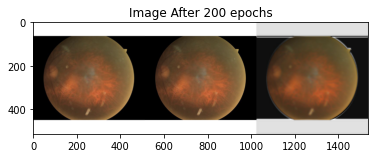

Epoch:200 batch[4/32] loss:0.034377533942461014


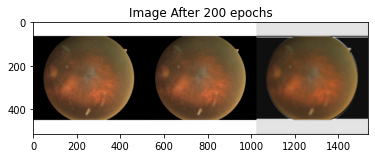

Epoch:200 batch[5/32] loss:0.030505036935210228


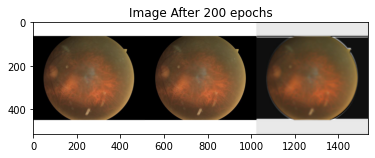

Epoch:200 batch[6/32] loss:0.020785819739103317


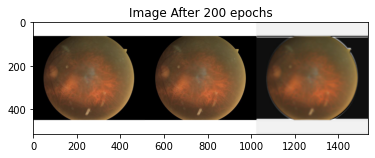

Epoch:200 batch[7/32] loss:0.0279605221003294


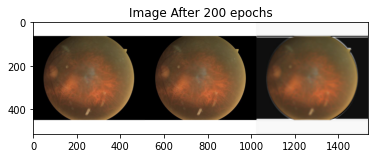

Epoch:200 batch[8/32] loss:0.02166922390460968


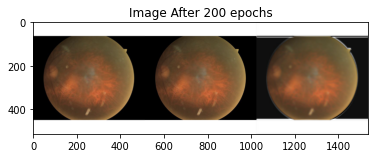

Epoch:200 batch[9/32] loss:0.07002133876085281


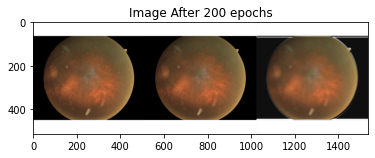

Epoch:200 batch[10/32] loss:0.05066471919417381


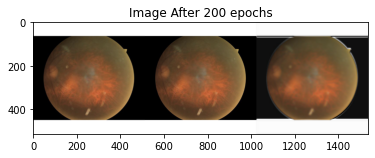

Epoch:200 batch[11/32] loss:0.026258479803800583


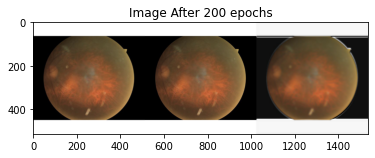

Epoch:200 batch[12/32] loss:0.04615499824285507


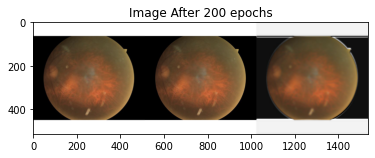

Epoch:200 batch[13/32] loss:0.050609711557626724


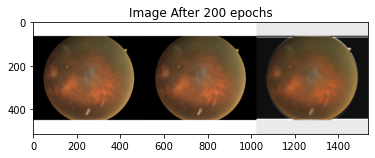

Epoch:200 batch[14/32] loss:0.007402119692414999


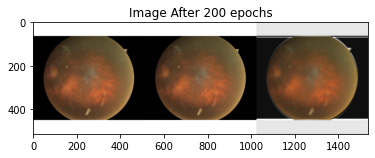

Epoch:200 batch[15/32] loss:0.02958172746002674


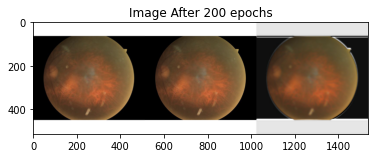

Epoch:200 batch[16/32] loss:0.02764073945581913


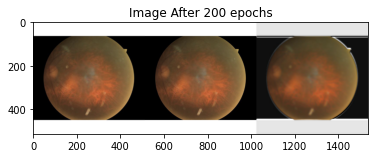

Epoch:200 batch[17/32] loss:0.031765833497047424


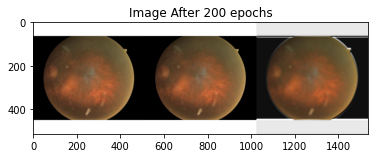

Epoch:200 batch[18/32] loss:0.016912980005145073


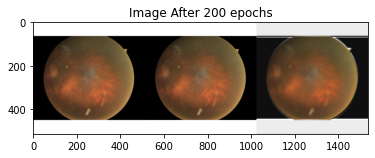

Epoch:200 batch[19/32] loss:0.06319183111190796


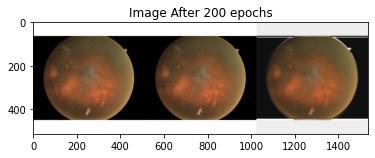

Epoch:200 batch[20/32] loss:0.02515847608447075


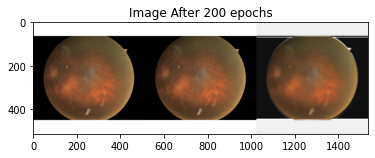

Epoch:200 batch[21/32] loss:0.014366870746016502


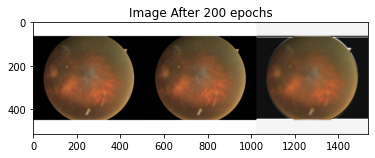

Epoch:200 batch[22/32] loss:0.033660463988780975


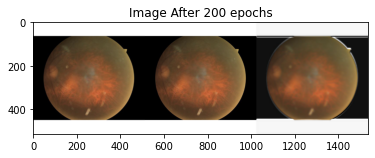

Epoch:200 batch[23/32] loss:0.04715730994939804


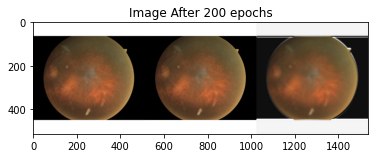

Epoch:200 batch[24/32] loss:0.057034384459257126


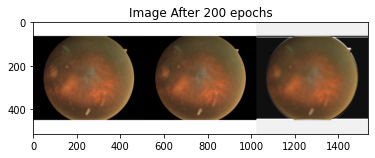

Epoch:200 batch[25/32] loss:0.054834894835948944


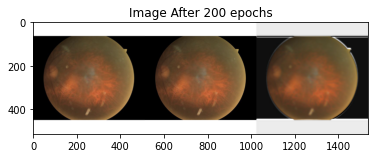

Epoch:200 batch[26/32] loss:0.05519683286547661


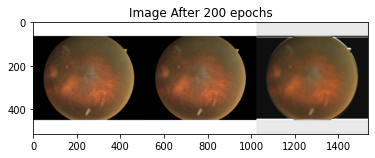

Epoch:200 batch[27/32] loss:0.029603395611047745


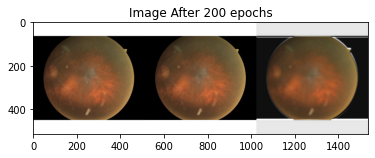

Epoch:200 batch[28/32] loss:0.02318907529115677


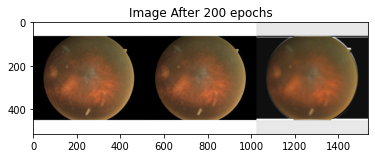

Epoch:200 batch[29/32] loss:0.032425761222839355


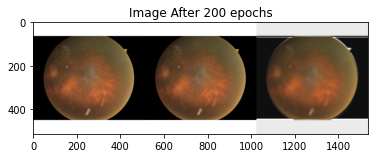

Epoch:200 batch[30/32] loss:0.0451631098985672


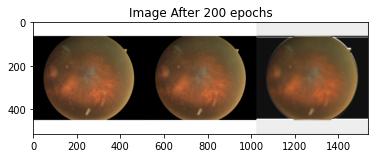

Epoch:200 batch[31/32] loss:0.045622069388628006


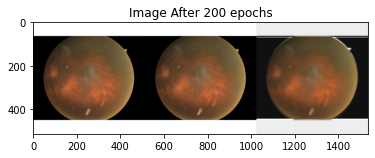

In [9]:
n_epochs=200
train(NUM_EPOCHS=n_epochs)

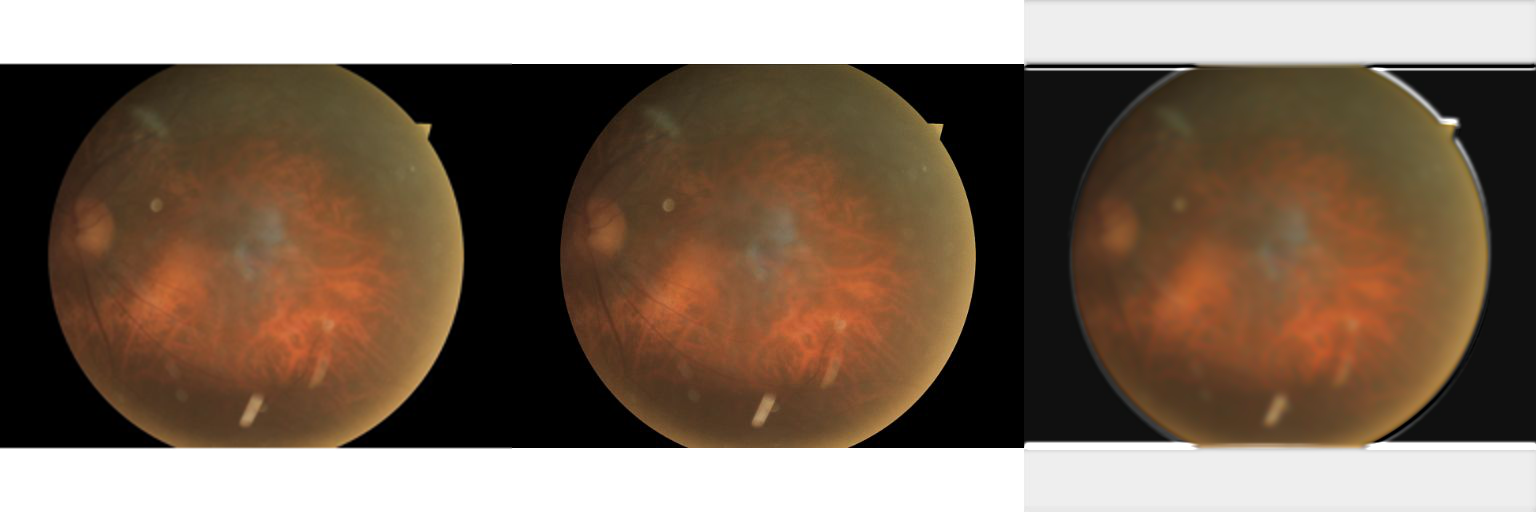

In [10]:
Image.open(f'/tmp/image/image{n_epochs}.png')

In [ ]:
# from IPython.display import FileLink
#FileLink('./image/image.png')
#FileLink('./image/LR.png')
#FileLink('./image/HR.png')
#FileLink('./image/newHR.png')

In [11]:
os.system('mkdir HR_1_imgs')
os.system('mkdir SR_1_imgs')

0

In [12]:
os.system('mkdir HR_0_imgs')
os.system('mkdir SR_0_imgs')

0

In [24]:
# total_bicubic_psnr = 0.0
# total_test_psnr = 0.0

for index, test_img_path in enumerate(test_img_pneumonia_paths[:]):
    #print("Epoch:{} batch[{}/{}] loss:{}".format(epoch+1, batch_idx+1, len(train_loader), loss))    
    
    data_transform = Compose([ToTensor()])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    img = Image.open(test_img_path)   

    w, h = img.size

    result_image = img
    result_image_y, _cb, _cr = result_image.convert('YCbCr').split()
    result_image_y = data_transform(result_image_y)   

    resize_image = img.resize((int(w/3), int(h/3)), Image.BICUBIC)       
    resize_image = resize_image.resize((w, h), Image.BICUBIC)
    resize_image_y, _cb, _cr = resize_image.convert('YCbCr').split()
    resize_image_y = data_transform(resize_image_y).to(device)
    newHR = SRCNN(resize_image_y.unsqueeze(0))
    out_img_y = newHR[0]
    out_img_y *= 255.0
    out_img_y = out_img_y.cpu().data.numpy()
    # Restore the image in RGB color space.
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = out_img_y.reshape((np.shape(out_img_y)[1], np.shape(out_img_y)[2]))
    out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
    out_img_cb = _cb.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img_cr = _cr.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert("RGB")
    
#     plot_results(resize_image_y, index, "lowres")
#     plot_results(result_image_y, index, "highres")
#     plot_results(newHR, index, "prediction")

#     torchvision.utils.save_image(resize_image_y, f'./output/LR{index+1}.png')
    result_image.save(f'./HR_1_imgs/HR{index+1}.png')
    out_img.save(f'./SR_1_imgs/SR{index+1}.png')

#     im1 = Image.open(f'./output/LR{index+1}.png')
#     im2 = Image.open(f'./output/HR{index+1}.png')
#     im3 = Image.open(f'./output/newHR{index+1}.png')                
#     dst = Image.new('RGB', (w*3 , h))
#     dst.paste(im1, (0, 0))
#     dst.paste(im2, (w, 0))
#     dst.paste(im3, (w*2, 0))
    
#     dst.save(f'./output/image{index+1}.png')
#     img = Image.open(f'./output/image{index+1}.png')
#     plt.imshow(img)
#     plt.title(f'Test Image {index+1}')
#     plt.show()

In [25]:
# total_bicubic_psnr = 0.0
# total_test_psnr = 0.0

for index, test_img_path in enumerate(test_img_normal_paths[:]):
    #print("Epoch:{} batch[{}/{}] loss:{}".format(epoch+1, batch_idx+1, len(train_loader), loss))    
    
    data_transform = Compose([ToTensor()])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    img = Image.open(test_img_path)   

    w, h = img.size

    result_image = img
    result_image_y, _cb, _cr = result_image.convert('YCbCr').split()
    result_image_y = data_transform(result_image_y)   

    resize_image = img.resize((int(w/3), int(h/3)), Image.BICUBIC)       
    resize_image = resize_image.resize((w, h), Image.BICUBIC)
    resize_image_y, _cb, _cr = resize_image.convert('YCbCr').split()
    resize_image_y = data_transform(resize_image_y).to(device)
    newHR = SRCNN(resize_image_y.unsqueeze(0))
    out_img_y = newHR[0]
    out_img_y *= 255.0
    out_img_y = out_img_y.cpu().data.numpy()
    # Restore the image in RGB color space.
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = out_img_y.reshape((np.shape(out_img_y)[1], np.shape(out_img_y)[2]))
    out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
    out_img_cb = _cb.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img_cr = _cr.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert("RGB")
    
#     plot_results(resize_image_y, index, "lowres")
#     plot_results(result_image_y, index, "highres")
#     plot_results(newHR, index, "prediction")

#     torchvision.utils.save_image(resize_image_y, f'./output/LR{index+1}.png')
    result_image.save(f'./HR_0_imgs/HR{index+1}.png')
    out_img.save(f'./SR_0_imgs/SR{index+1}.png')

#     im1 = Image.open(f'./output/LR{index+1}.png')
#     im2 = Image.open(f'./output/HR{index+1}.png')
#     im3 = Image.open(f'./output/newHR{index+1}.png')                
#     dst = Image.new('RGB', (w*3 , h))
#     dst.paste(im1, (0, 0))
#     dst.paste(im2, (w, 0))
#     dst.paste(im3, (w*2, 0))
    
#     dst.save(f'./output/image{index+1}.png')
#     img = Image.open(f'./output/image{index+1}.png')
#     plt.imshow(img)
#     plt.title(f'Test Image {index+1}')
#     plt.show()

In [26]:
%%!

zip -r HR_0_imgs.zip ./HR_0_imgs

['updating: HR_0_imgs/ (stored 0%)',
 '  adding: HR_0_imgs/HR67.png (deflated 2%)',
 '  adding: HR_0_imgs/HR92.png (deflated 1%)',
 '  adding: HR_0_imgs/HR186.png (deflated 1%)',
 '  adding: HR_0_imgs/HR115.png (deflated 1%)',
 '  adding: HR_0_imgs/HR114.png (deflated 1%)',
 '  adding: HR_0_imgs/HR96.png (deflated 1%)',
 '  adding: HR_0_imgs/HR75.png (deflated 1%)',
 '  adding: HR_0_imgs/HR91.png (deflated 2%)',
 '  adding: HR_0_imgs/HR167.png (deflated 1%)',
 '  adding: HR_0_imgs/HR13.png (deflated 1%)',
 '  adding: HR_0_imgs/HR37.png (deflated 1%)',
 '  adding: HR_0_imgs/HR140.png (deflated 1%)',
 '  adding: HR_0_imgs/HR199.png (deflated 1%)',
 '  adding: HR_0_imgs/HR97.png (deflated 1%)',
 '  adding: HR_0_imgs/HR166.png (deflated 1%)',
 '  adding: HR_0_imgs/HR136.png (deflated 1%)',
 '  adding: HR_0_imgs/HR62.png (deflated 1%)',
 '  adding: HR_0_imgs/HR40.png (deflated 1%)',
 '  adding: HR_0_imgs/HR145.png (deflated 1%)',
 '  adding: HR_0_imgs/HR23.png (deflated 1%)',
 '  adding: HR

In [27]:
%%!

zip -r SR_0_imgs.zip ./SR_0_imgs

['updating: SR_0_imgs/ (stored 0%)',
 '  adding: SR_0_imgs/SR59.png (deflated 1%)',
 '  adding: SR_0_imgs/SR32.png (deflated 1%)',
 '  adding: SR_0_imgs/SR28.png (deflated 1%)',
 '  adding: SR_0_imgs/SR149.png (deflated 1%)',
 '  adding: SR_0_imgs/SR136.png (deflated 1%)',
 '  adding: SR_0_imgs/SR111.png (deflated 1%)',
 '  adding: SR_0_imgs/SR72.png (deflated 1%)',
 '  adding: SR_0_imgs/SR194.png (deflated 2%)',
 '  adding: SR_0_imgs/SR110.png (deflated 1%)',
 '  adding: SR_0_imgs/SR140.png (deflated 1%)',
 '  adding: SR_0_imgs/SR164.png (deflated 1%)',
 '  adding: SR_0_imgs/SR116.png (deflated 1%)',
 '  adding: SR_0_imgs/SR188.png (deflated 1%)',
 '  adding: SR_0_imgs/SR6.png (deflated 1%)',
 '  adding: SR_0_imgs/SR60.png (deflated 1%)',
 '  adding: SR_0_imgs/SR20.png (deflated 1%)',
 '  adding: SR_0_imgs/SR94.png (deflated 1%)',
 '  adding: SR_0_imgs/SR159.png (deflated 1%)',
 '  adding: SR_0_imgs/SR49.png (deflated 1%)',
 '  adding: SR_0_imgs/SR65.png (deflated 1%)',
 '  adding: SR

In [28]:
%%!

zip -r HR_1_imgs.zip ./HR_1_imgs

['updating: HR_1_imgs/ (stored 0%)',
 '  adding: HR_1_imgs/HR67.png (deflated 2%)',
 '  adding: HR_1_imgs/HR92.png (deflated 1%)',
 '  adding: HR_1_imgs/HR186.png (deflated 2%)',
 '  adding: HR_1_imgs/HR115.png (deflated 1%)',
 '  adding: HR_1_imgs/HR114.png (deflated 1%)',
 '  adding: HR_1_imgs/HR96.png (deflated 1%)',
 '  adding: HR_1_imgs/HR75.png (deflated 0%)',
 '  adding: HR_1_imgs/HR91.png (deflated 1%)',
 '  adding: HR_1_imgs/HR202.png (deflated 1%)',
 '  adding: HR_1_imgs/HR167.png (deflated 1%)',
 '  adding: HR_1_imgs/HR13.png (deflated 1%)',
 '  adding: HR_1_imgs/HR37.png (deflated 2%)',
 '  adding: HR_1_imgs/HR140.png (deflated 1%)',
 '  adding: HR_1_imgs/HR199.png (deflated 1%)',
 '  adding: HR_1_imgs/HR97.png (deflated 1%)',
 '  adding: HR_1_imgs/HR166.png (deflated 1%)',
 '  adding: HR_1_imgs/HR136.png (deflated 2%)',
 '  adding: HR_1_imgs/HR62.png (deflated 1%)',
 '  adding: HR_1_imgs/HR40.png (deflated 2%)',
 '  adding: HR_1_imgs/HR145.png (deflated 1%)',
 '  adding: H

In [29]:
%%!

zip -r SR_1_imgs.zip ./SR_1_imgs

['updating: SR_1_imgs/ (stored 0%)',
 '  adding: SR_1_imgs/SR59.png (deflated 1%)',
 '  adding: SR_1_imgs/SR32.png (deflated 1%)',
 '  adding: SR_1_imgs/SR28.png (deflated 1%)',
 '  adding: SR_1_imgs/SR149.png (deflated 1%)',
 '  adding: SR_1_imgs/SR136.png (deflated 1%)',
 '  adding: SR_1_imgs/SR111.png (deflated 1%)',
 '  adding: SR_1_imgs/SR72.png (deflated 1%)',
 '  adding: SR_1_imgs/SR194.png (deflated 1%)',
 '  adding: SR_1_imgs/SR110.png (deflated 1%)',
 '  adding: SR_1_imgs/SR140.png (deflated 2%)',
 '  adding: SR_1_imgs/SR164.png (deflated 1%)',
 '  adding: SR_1_imgs/SR116.png (deflated 1%)',
 '  adding: SR_1_imgs/SR188.png (deflated 1%)',
 '  adding: SR_1_imgs/SR6.png (deflated 2%)',
 '  adding: SR_1_imgs/SR60.png (deflated 1%)',
 '  adding: SR_1_imgs/SR20.png (deflated 1%)',
 '  adding: SR_1_imgs/SR94.png (deflated 1%)',
 '  adding: SR_1_imgs/SR159.png (deflated 1%)',
 '  adding: SR_1_imgs/SR49.png (deflated 1%)',
 '  adding: SR_1_imgs/SR65.png (deflated 1%)',
 '  adding: SR